In [10]:
# cnn model with batch normalization for mnist
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization

import glob
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
#os.chdir("drive/MyDrive/Thesis")
# Going to the folder that containes the data
#os.chdir("PVDefectsDS/Update28Feb2023/Serie1Update/")

In [13]:
png_folder_path = "CellsGS/"
mat_folder_path = "MaskGT/"

# Get a list of all PNG files in the folder
png_file_paths = glob.glob(os.path.join(png_folder_path, "*.png"))

# Load each PNG file as a numpy array and add it to a list
png_arrays = []
#i = 0
for png_file_path in png_file_paths:
    with Image.open(png_file_path) as img:
        png_arrays.append(np.array(img))
        #if i == 1:
            #print(png_file_path)
        #i = i + 1


In [14]:
#png_arrays

In [15]:
#reshape the image so they are the same size 
common_size = (256, 256)
resized_png_arrays = []
i = 0
for png_array in png_arrays:
    png_img = Image.fromarray(png_array)
    resized_png_img = png_img.resize(common_size)
    resized_png_array = np.array(resized_png_img)
    resized_png_arrays.append(resized_png_array)

In [16]:
fault_arrays = []
i = 0
for png_file_path in png_file_paths:
    png_file_name = os.path.splitext(os.path.basename(png_file_path))[0]
    png_file_name = png_file_name.replace("ImageGS", "Image")
    mask_file_name = f"GT_{png_file_name}.mat"
    mask_file_path = os.path.join(mat_folder_path, mask_file_name)
    
    # Load the mask file as a numpy array, or create an artificial mask if the file does not exist
    if os.path.exists(mask_file_path):
      fault_arrays.append(1)
    else:
      fault_arrays.append(0)

In [17]:
print(f'Amount of cells in the dateset: {len(fault_arrays)}')
print(f'Amount of cells with faults: {sum(fault_arrays)}')

Amount of cells in the dateset: 8700
Amount of cells with faults: 599


In [51]:
X_train, X_test, y_train, y_test = train_test_split(resized_png_arrays, fault_arrays, test_size=0.2, random_state=42)
# Split train data into train and validation sets (75/25 split)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [52]:
height, width = 256, 256
X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)
X_train = X_train.reshape((-1, height, width, 1))
X_test = X_test.reshape((-1, height, width, 1))
X_val = X_val.reshape((-1,height, width, 1))


print(f"Amount of faulty cells in the training data: {sum(y_train)}")
print(f"Amount of faulty cells in the testing data: {sum(y_test)}")
print(f"Amount of faulty cells in the tvalidation data: {sum(y_val)}")
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

Amount of faulty cells in the training data: 353
Amount of faulty cells in the testing data: 117
Amount of faulty cells in the tvalidation data: 129


In [21]:
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(256, 256, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dense(2, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9) 
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = define_model()

In [27]:
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs = 3, batch_size = 100, verbose=0)

In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [28]:
history.history['accuracy']

[0.9318007826805115,
 0.9331417679786682,
 0.936398446559906,
 0.9461686015129089,
 0.9611111283302307]

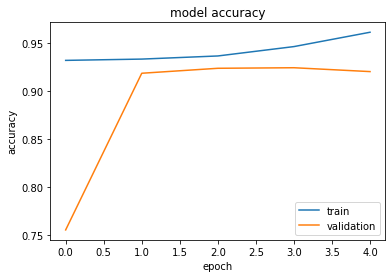

In [30]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [67]:
y_pred = model.predict(X_test)

55/55 [==============================] - 53s 950ms/step


In [68]:
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from sklearn.metrics import roc_curve

In [55]:
y_pred1 = y_pred
y_test1 = y_test
print(y_pred1)
y_pred1 = tf.math.argmax(y_pred1, axis=1)
y_test1 = tf.math.argmax(y_test1, axis=1)
print(np.asarray(y_pred1))
print(np.asarray(y_test1))

[[9.9393225e-01 6.0677719e-03]
 [9.8963654e-01 1.0363431e-02]
 [9.9934250e-01 6.5745937e-04]
 ...
 [9.8233336e-01 1.7666677e-02]
 [9.8582757e-01 1.4172426e-02]
 [9.8768276e-01 1.2317268e-02]]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


In [64]:
cm = confusion_matrix(y_test1,y_pred1)
print(cm)
tp = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tn = cm[1][1]
#print(cm[1][0])
recall = tp/(tp+fn)
print(f"The recall of the test dataset is: {recall}")

[[1607   16]
 [ 113    4]]
The recall of the test dataset is: 0.9343023255813954


From the confussion matrix we can see that we have 1607 cases of True positives, 113 of false negatives, 16 cases of false positives and 4 cases of true negatives. 

In [72]:
# predict probabilities
print(classification_report(y_test1, y_pred1))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1623
           1       0.20      0.03      0.06       117

    accuracy                           0.93      1740
   macro avg       0.57      0.51      0.51      1740
weighted avg       0.88      0.93      0.90      1740

